In [15]:
#Import libraries
library(ggplot2) # Data visualization
library(RSQLite)
library(plyr)
library(dplyr, warn.conflicts = FALSE)

#Connect to the database 
db <- dbConnect(SQLite(),"~/Downloads/soccer/database.sqlite")
Country <- dbGetQuery(db,"Select * from Country")
Match <- dbGetQuery(db,"Select * from Match")
League <- dbGetQuery(db,"Select * from League")
Team <- dbGetQuery(db,"Select * from Team")

skill_stats <- c(
    'height',
    'weight',
    'overall_rating',
    'crossing',
    'finishing',
    'heading_accuracy',
    'short_passing',
    'volleys',
    'dribbling',
    'curve',
    'free_kick_accuracy',
    'long_passing',
    'ball_control',
    'acceleration',
    'sprint_speed',
    'agility',
    'reactions',
    'balance',
    'shot_power',
    'jumping',
    'stamina',
    'strength',
    'long_shots',
    'aggression',
    'interceptions',
    'positioning',
    'vision',
    'penalties',
    'marking',
    'standing_tackle',
    'sliding_tackle',
    'gk_diving',
    'gk_handling',
    'gk_kicking',
    'gk_positioning',
    'gk_reflexes'
)

attributes <- c(
    'player_name',
    'date',
    'Player.player_fifa_api_id',
    'Player.player_api_id',
    'preferred_foot',
    'attacking_work_rate',
    'defensive_work_rate',
    skill_stats
)
cols <- paste(attributes, collapse=",")

Player <- dbGetQuery(db, sprintf("SELECT %s FROM Player JOIN Player_Attributes ON Player.player_api_id = Player_Attributes.player_api_id", cols))

#Count the number of matches the particular team played at home
home_match = count(Match,home_team_api_id)
away_match = count(Match,away_team_api_id)
#change names of the column n to number of matches
names(home_match)[names(home_match)=="n"] <- "home_matches_number"
names(away_match)[names(away_match)=="n"] <- "away_matches_number"

In [16]:
head(Player)

player_name,date,player_fifa_api_id,player_api_id,preferred_foot,attacking_work_rate,defensive_work_rate,height,weight,overall_rating,⋯,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
Aaron Appindangoye,2016-02-18 00:00:00,218353,505942,right,medium,medium,182.88,187,67,⋯,54,48,65,69,69,6,11,10,8,8
Aaron Appindangoye,2015-11-19 00:00:00,218353,505942,right,medium,medium,182.88,187,67,⋯,54,48,65,69,69,6,11,10,8,8
Aaron Appindangoye,2015-09-21 00:00:00,218353,505942,right,medium,medium,182.88,187,62,⋯,54,48,65,66,69,6,11,10,8,8
Aaron Appindangoye,2015-03-20 00:00:00,218353,505942,right,medium,medium,182.88,187,61,⋯,53,47,62,63,66,5,10,9,7,7
Aaron Appindangoye,2007-02-22 00:00:00,218353,505942,right,medium,medium,182.88,187,61,⋯,53,47,62,63,66,5,10,9,7,7
Aaron Cresswell,2016-04-21 00:00:00,189615,155782,left,high,medium,170.18,146,74,⋯,66,59,76,75,78,14,7,9,9,12


In [27]:
# Combine these two dataframes
new_match_data <- cbind(home_match, away_match)

new_match_data <- new_match_data %>% mutate(
    total_matches = home_matches_number + away_matches_number,
    wins = 0,
    win_percentage = 0,
    points = 0,
    points_average = 0,
    country = "",
    team_name = ""
)

#Find the country of the team and append in the country coloumn
for(row1 in rownames(new_match_data))
{
    home_indexes = which(Match$home_team_api_id == new_match_data$home_team_api_id[as.numeric(row1)])
    new_match_data$country[as.numeric(row1)] <- Country$name[Country$id==Match$country_id[as.numeric(home_indexes[1])]]
    new_match_data$team_name[as.numeric(row1)] <- Team$team_long_name[Team$team_api_id==new_match_data$home_team_api_id[as.numeric(row1)]]
}
#Drop the unnecessary columns "home_matches_number" and "away_matches_number"
drops_columns <- c("home_matches_number","away_matches_number")
new_match_data <- new_match_data[ , !(names(new_match_data) %in% drops_columns)]

print("Removed unnecessary columns")
print(head(new_match_data))

[1] "Removed unnecessary columns"
  home_team_api_id away_team_api_id total_matches wins win_percentage points
1             1601             1601           240    0              0      0
2             1773             1773            90    0              0      0
3             1957             1957           240    0              0      0
4             2033             2033           150    0              0      0
5             2182             2182           240    0              0      0
6             2183             2183           150    0              0      0
  points_average  country             team_name
1              0   Poland          Ruch Chorzów
2              0  Belgium   Oud-Heverlee Leuven
3              0   Poland Jagiellonia Białystok
4              0 Portugal        S.C. Olhanense
5              0   Poland           Lech Poznań
6              0   Poland           P. Warszawa


In [28]:
#Iterate over all the teams ids 
for(id in rownames(new_match_data)) {
    # win_count stores the number of wins if the current team has scored more goals than the opponent team.
    win_count <- 0
    points <- 0
    #Find all the records in main "Match" table which match the current team id
    home_indexes <- which(Match$home_team_api_id == new_match_data$home_team_api_id[as.numeric(id)])
    away_indexes <- which(Match$away_team_api_id == new_match_data$away_team_api_id[as.numeric(id)])
    
    for(i in home_indexes)
    {
        if(Match$home_team_goal[i] > Match$away_team_goal[i])
        {
            win_count <- win_count +1
            points <- points + 3
        }
        
        if (Match$home_team_goal[i] == Match$away_team_goal[i])
        {
            points <- points + 1
        }
    }
    
    for(i in away_indexes)
    {
        if (Match$away_team_goal[i] > Match$home_team_goal[i])
        {
            win_count <- win_count + 1
            points <- points + 3
        }
        
        if (Match$away_team_goal[i] == Match$home_team_goal[i])
        {
            points <- points + 1
        }
    }
    
    new_match_data$wins[as.numeric(id)] <- win_count
    new_match_data$points[as.numeric(id)] <- points
    new_match_data$win_percentage[as.numeric(id)] <- as.double(win_count/new_match_data$total_matches[as.numeric(id)]*100)
    new_match_data$points_average[as.numeric(id)] <- as.double(points/new_match_data$total_matches[as.numeric(id)])
}

# Drop Away_team_id column and change home_team_api_id columns name to team_id
drop_columns <- c("away_team_api_id")
new_match_data <- new_match_data[ , !names(new_match_data) %in% drop_columns]
names(new_match_data)[names(new_match_data)=="home_team_api_id"]<-"team_id"

#Sort the teams based on the winning percentage
sorted_teams_by_wins <- new_match_data[order(-new_match_data$win_percentage),]
sorted_teams_by_points <- new_match_data[order(-new_match_data$points_average),]

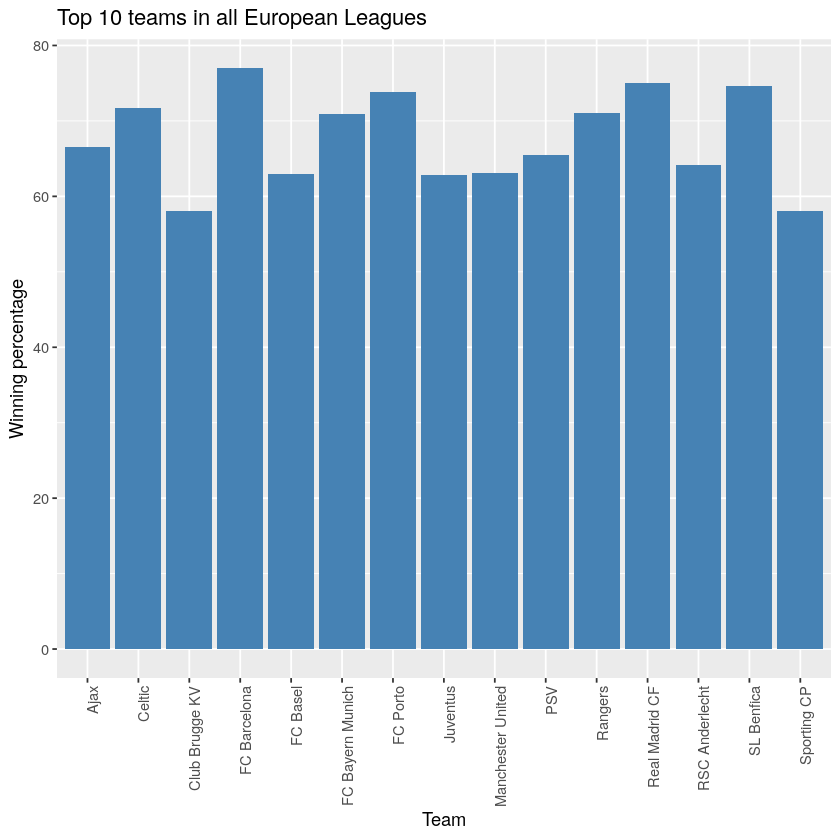

In [32]:
ggplot(data=sorted_teams_by_wins[0:15,], aes(x=team_name,y=win_percentage)) + 
geom_bar(stat="identity", fill="steelblue")+labs(x="Team",y="Winning percentage")+
ggtitle("Top 10 teams in all European Leagues")+theme(axis.text.x = element_text(angle = 90, hjust = 1))


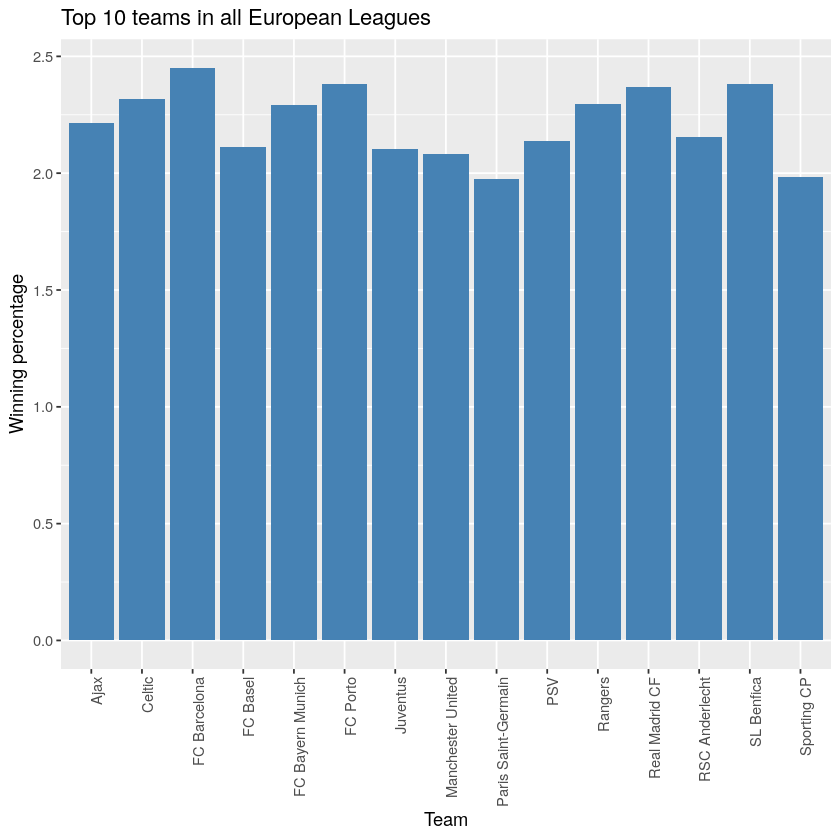

In [33]:
ggplot(data=sorted_teams_by_points[0:15,], aes(x=team_name,y=points_average)) + 
geom_bar(stat="identity", fill="steelblue")+labs(x="Team",y="Winning percentage")+
ggtitle("Top 10 teams in all European Leagues")+theme(axis.text.x = element_text(angle = 90, hjust = 1))

In [6]:
plot_top_teams <- function(n, country) {
    league_team <- sorted_data[sorted_data$country==country,]
    league <- league_team[order(-league_team$win_percentage),][1:n,]
    ggplot(data=league,aes(x=team_name,y=win_percentage))+
    geom_bar(stat='identity',fill="firebrick ")+labs(x="Team",y="Winning Percentage")+
    ggtitle(sprintf("Top %d Teams in %s League", n, country))+theme(axis.text.x = element_text(angle = 90, hjust = 1))
}

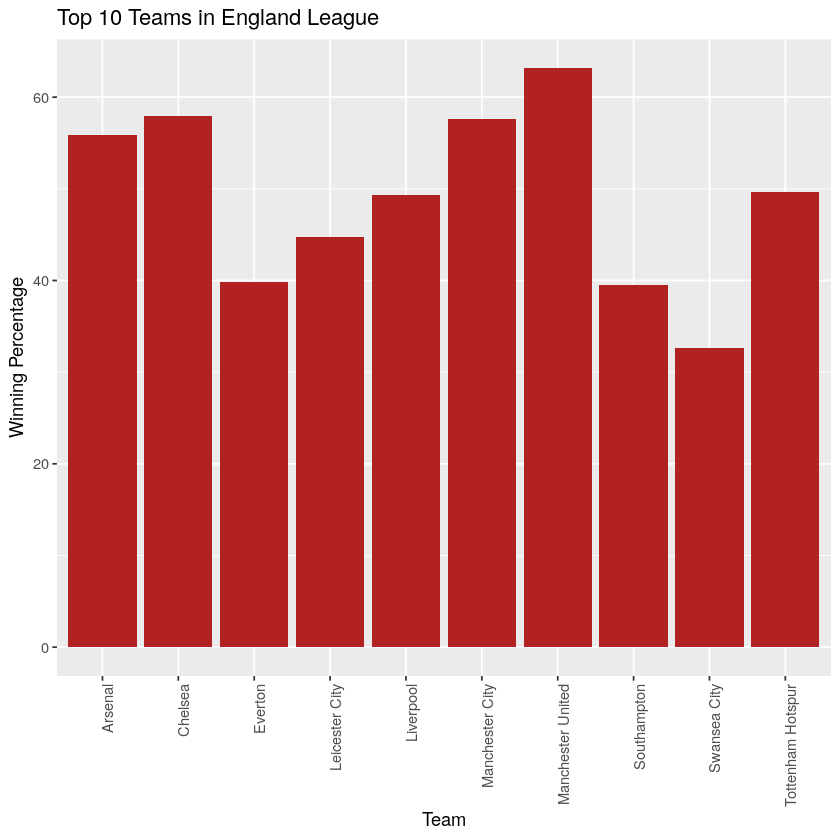

In [7]:
plot_top_teams(10, "England")

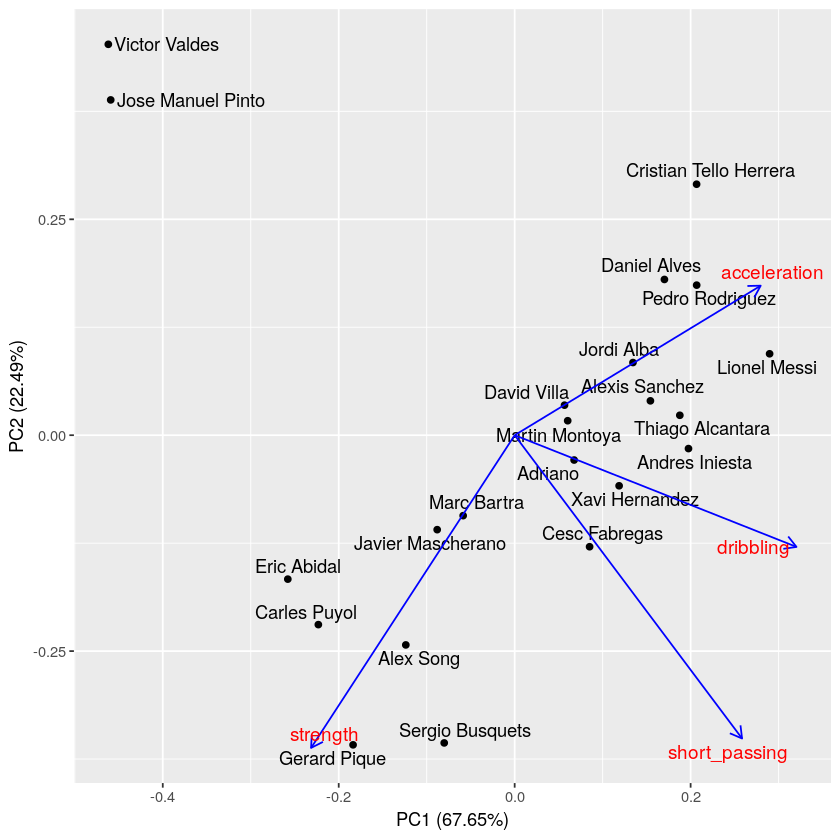

In [8]:
get_team_players_by_name <- function(team_name) {
    query <- paste0("SELECT * FROM Team WHERE team_long_name LIKE '%", team_name, "%'")
    team_api_id <- dbGetQuery(db, query)$team_api_id
    home_team_matches <- dbGetQuery(db, sprintf("SELECT * FROM Match WHERE home_team_api_id = %s", team_api_id))
    away_team_matches <- dbGetQuery(db, sprintf("SELECT * FROM Match WHERE away_team_api_id = %s", team_api_id))

    # remove fields with nulls
    home_team_matches <- na.omit(home_team_matches)
    away_team_matches <- na.omit(away_team_matches)

    # get the player attributes closest to the date
    get_player_attributes <- function(player_api_id, match_date = Sys.Date()) {
        versions <- Player[Player$player_api_id == player_api_id,]
        versions[order(abs(difftime(versions$date, match_date))),][1,]
    }
    all_players <- list()
    for (i in 1:11) {
        home_players <- as.list(home_team_matches[sprintf("home_player_%d", i)])
        away_players <- as.list(away_team_matches[sprintf("away_player_%d", i)])
        all_players <- append(unlist(all_players), unlist(home_players))
        all_players <- append(unlist(all_players), unlist(away_players))
    }
    all_players <- unique(all_players)
    # construct the dataframe
    team_df <- do.call(rbind, Map(function(x) data.frame(get_player_attributes(x)), x=all_players))
    # use player's name instead of numeric index
    rownames(team_df) <- team_df$player_name
    team_df
}
                                  
plot_pca_for_team <- function(team_name, attributes) {
    players_df <- get_team_players_by_name(team_name)
    pca <- prcomp(players_df[,attributes], center = TRUE,scale. = TRUE)
    library(ggrepel)  
    library(ggfortify)
    autoplot(pca, label = TRUE, label.repel = T, loadings = TRUE, loadings.colour = 'blue', loadings.label = TRUE, 
         loadings.label.size = 4, loading.label.color = 'red',loadings.label.repel=TRUE) 
}
plot_pca_for_team("Barcelona", c("acceleration", "short_passing", "strength", "dribbling"))

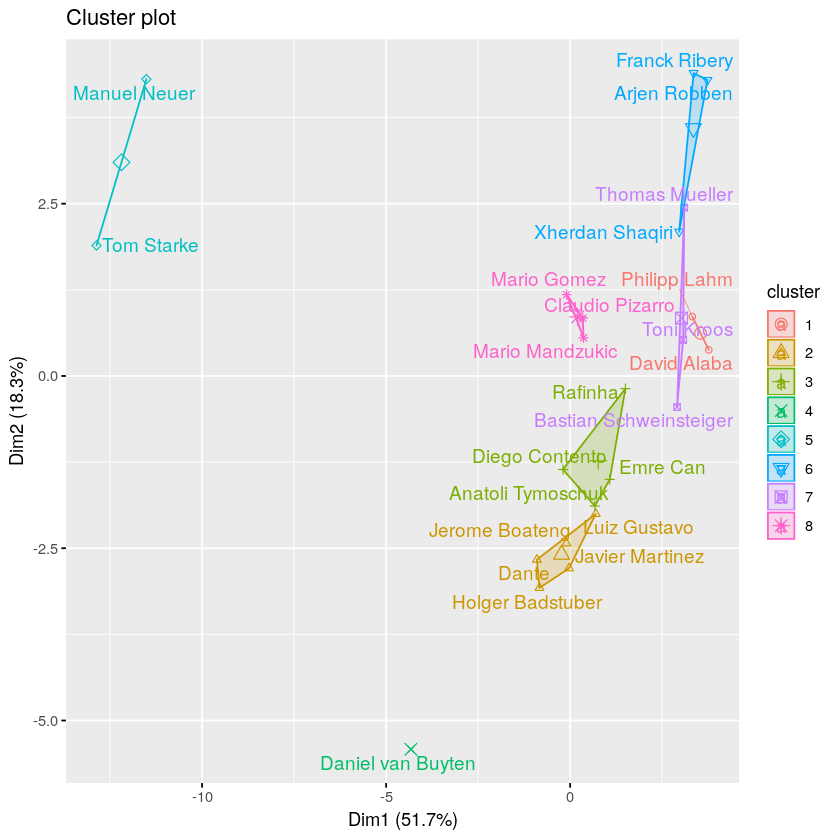

In [32]:
plot_clusters_for_team <- function(team_name, centers=5) {
    library(cluster)    # clustering algorithm
    library(factoextra) # visualization
    players_df <- get_team_players_by_name(team_name)
    players_df[skill_stats] <- scale(players_df[skill_stats])
    k5 <- kmeans(players_df[skill_stats], centers=centers, nstart = 25)
    fviz_cluster(k5, data = players_df, choose.vars=skill_stats, repel=TRUE) # prevent text overlapping
}

plot_h_clusters_for_team <- function(team_name) {
    players_df <- get_team_players_by_name(team_name)
    clusters <- hclust(dist(players_df[skill_stats]))
    plot(clusters,, main="Field positions hierarchy by skill stats")
}

plot_clusters_for_team("Bayern", 8)

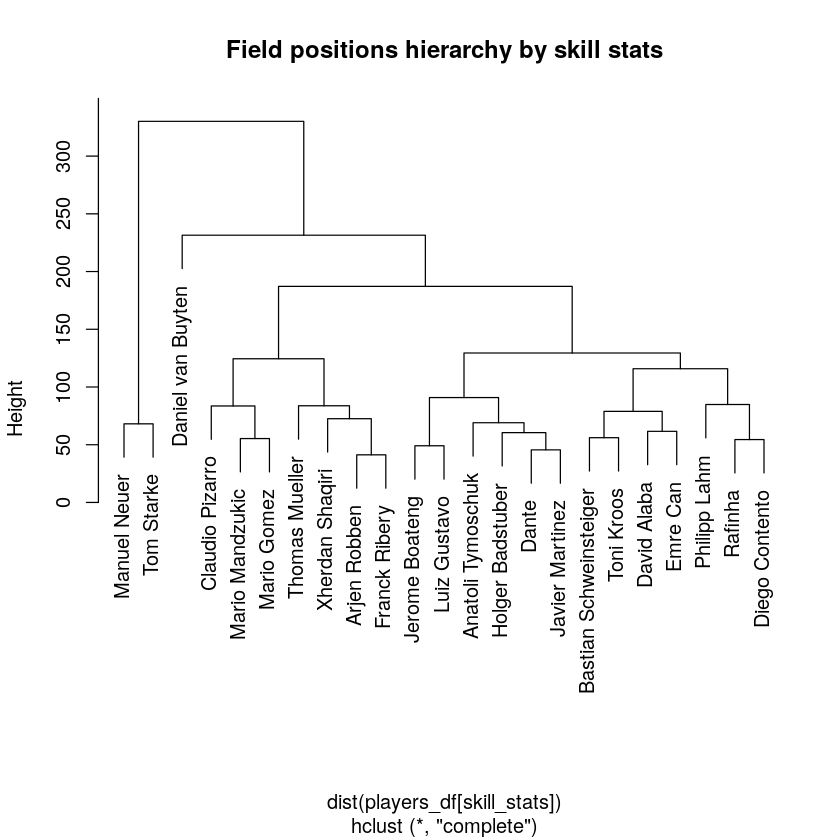

In [33]:
plot_h_clusters_for_team("Bayern")

In [34]:
# 0 - 9 | 0 - 11
nrow(Match)

head(Match)

[1] 25979

id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,⋯,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,⋯,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,⋯,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,⋯,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,⋯,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,⋯,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67
6,1,1,2008/2009,1,2008-09-24 00:00:00,492478,8203,8342,1,⋯,1.67,4.35,3.40,1.70,4.50,3.40,1.70,NA,NA,NA


In [35]:
matches <- na.omit(data.frame(Match))

betting_cols <- colnames(matches)[toupper(colnames(matches)) == colnames(matches)]

matches$goals_diff <- matches$home_team_goal - matches$away_team_goal
matches$outcome <- ifelse(matches$goals_diff == 0, "D", ifelse(matches$goals_diff > 0, "W", "L"))

samplesize = 0.80 * nrow(matches)
set.seed(80)
index = sample( seq_len ( nrow ( matches ) ), size = samplesize )

matches <- matches[c(betting_cols, 'goals_diff')]

# Create training and test set
matches_train <- matches[index, ]
matches_test <- matches[-index, ]



In [36]:
library(e1071)
model <- svm(goals_diff ~ ., data = matches)

In [37]:
model


Call:
svm(formula = goals_diff ~ ., data = matches)


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  0.03333333 
    epsilon:  0.1 


Number of Support Vectors:  1534


In [14]:
players.df <- get_team_players_by_name('Bayern')
players.df <- scale(players.df[skill_stats])

nclusters <- 8
km.res <- kmeans(players.df, nclusters, nstart = 25)

### Sensitivity Analysis ###
table(km.res$cluster)

km.gr <- data.frame(Name = names(km.res$cluster), gr=km.res$cluster)

# variabila folosita pentru a echivala grupele din seturi de grupari
# ATENTIE: grupa 1 in set 1 poate fi o alta grupa in set 2!
gr.match <- data.frame(orig=unique(km.gr$gr), m=0)

seed.sample <- sample(1:10000, 100, replace=FALSE)


for (seed in seed.sample) {
    set.seed(seed)
    km.res2 <- kmeans(players.df, nclusters, nstart = 25)
    km.gr2 <- data.frame(Name = names(km.res2$cluster), gr=km.res2$cluster)

    for(gr in unique(km.gr$gr)) {
        tmp.names <- km.gr$Name[km.gr$gr == gr]
        tmp <- km.gr2[ km.gr2$Name %in% tmp.names , ]
        # print(head(tmp))
        tbl <- table(tmp$gr)
        gr.max.id <- as.numeric(names(tbl)[tbl == max(tbl)])
        gr.match[gr.match$orig == gr, "m"] <- gr.max.id
    }

    km.gr2.std <- data.frame(Name = km.gr2$Name, gr=0)
    for(gr in unique(km.gr2$gr)) {
        sel <- km.gr2$gr == gr
        km.gr2.std[sel , "gr"] <- gr.match[gr.match$m == gr, "orig"]
    }
    # TODO: proper Join
    km.gr[ , paste0("gr", seed)] <- km.gr2.std$gr
}


multiple_classes_f <- function(x.data) {
    if(length(unique(x.data[-1])) != 1) {
        return(1)
    }
    return(0)
}

count_differences_f <- function(x.data) {
    return (length(x.data) - sort(table(x.data),decreasing=TRUE)[1])
}

# identiicam randurile care contin 2 sau mai multe grupe
gr.diff <- apply(km.gr, MARGIN=1, multiple_classes_f)
table(gr.diff)

# numaram cat de des sunt grupate diferit
gr.dif.cnt <- apply(km.gr[gr.diff != 0 ,], MARGIN=1, count_differences_f)
print("Wrong")
table(gr.dif.cnt)
# fonturi in grupe multiple
# mai mult de cel putin 10 ori
print("DSADSA")
gr.dif.cnt[gr.dif.cnt >= 5]


1 2 3 4 5 6 7 8 
3 2 3 5 1 2 3 4 

gr.diff
 0 
23 

[1] "Wrong"


< table of extent 0 >

[1] "DSADSA"


named integer(0)

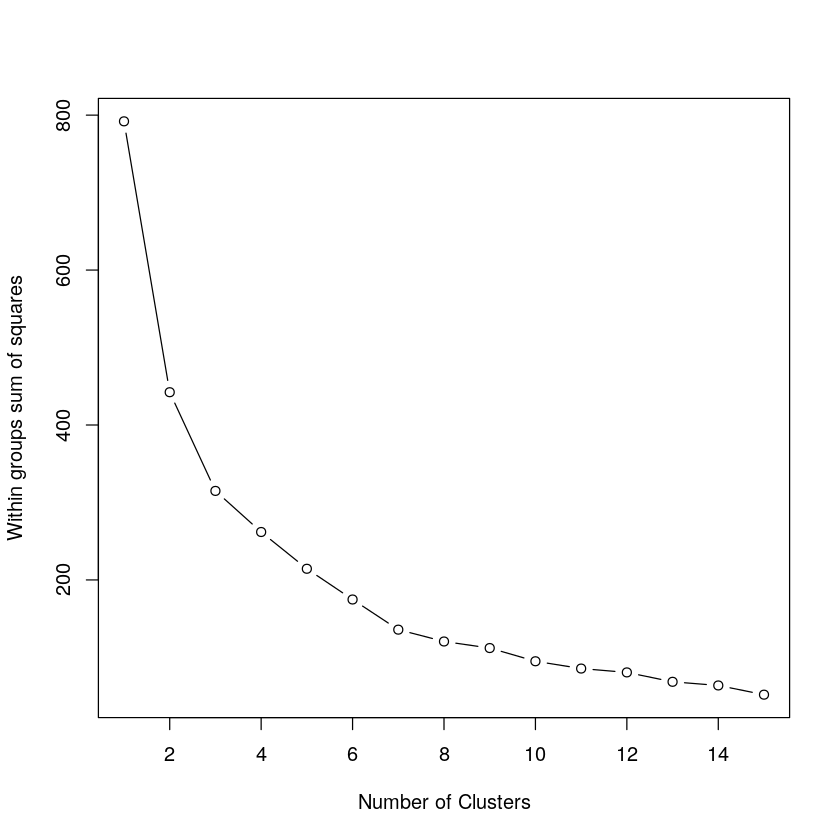

In [15]:
# Determine number of clusters
# folosind metoda elbow
wss <- (nrow(players.df) - 1) * sum(apply(players.df,2,var))
for (i in 2:15) wss[i] <- sum(kmeans(players.df,
   centers=i)$withinss)
plot(1:15, wss, type="b", xlab="Number of Clusters",
  ylab="Within groups sum of squares")

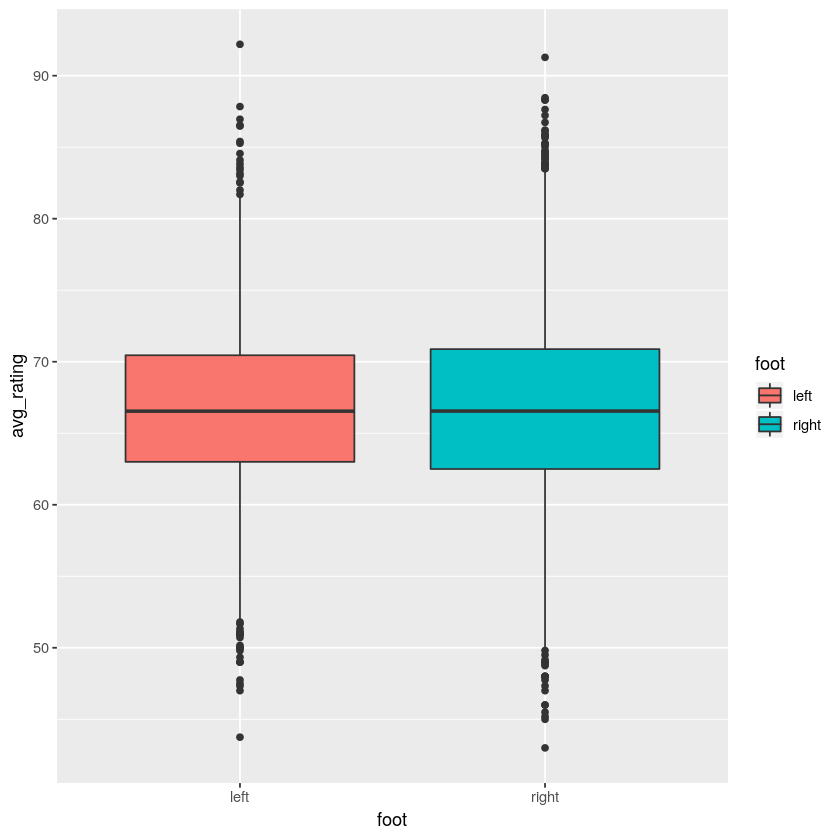

In [22]:
comparison <- Player %>%
  select(player_name, overall_rating, preferred_foot) %>%
  group_by(player_name) %>%
  summarise(avg_rating = mean(overall_rating), foot = names(which.max(table(preferred_foot))))

# make it a data.frame, so ggplot likes it
comparisonDF <- as.data.frame(comparison)

# check for NA's
# which(is.na(comparisonDF$avg_rating))

# There are 4 of them, so let us remove them
idx <- which(is.na(comparisonDF$avg_rating))
comparisonDF <- comparisonDF[-idx,]



# produce boxplot with ggplot
ggplot(comparisonDF, aes(fill = foot)) + 
    geom_boxplot(aes(x = foot, y = avg_rating))


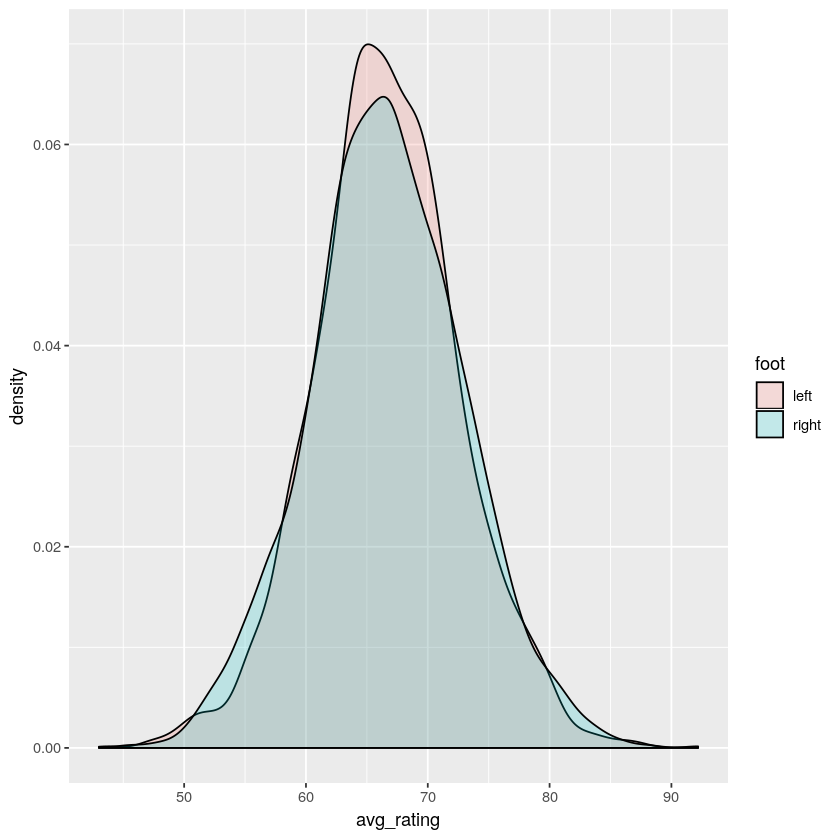

In [24]:
ggplot(comparisonDF, aes(x = avg_rating, fill = foot)) + 
    geom_density(alpha = 0.2)

In [23]:
lefties <- comparison %>%
  filter(foot == "left") %>%
  arrange(desc(avg_rating))

righties <- comparison %>%
  filter(foot == "right") %>%
  arrange(desc(avg_rating))

ks.test(lefties$avg_rating, righties$avg_rating)

Warning message in ks.test(lefties$avg_rating, righties$avg_rating):
“p-value will be approximate in the presence of ties”


	Two-sample Kolmogorov-Smirnov test

data:  lefties$avg_rating and righties$avg_rating
D = 0.029074, p-value = 0.08731
alternative hypothesis: two-sided
